# Imports and Setup

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


# Vector Quantizer

In [ ]:
class VectorQuantizer(nn.Module):
    """
    Vector Quantization layer - the core of VQ-VAE
    """
    def __init__(self, num_embeddings, embedding_dim, commitment_cost=0.25):
        super(VectorQuantizer, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost

        # Initialize embeddings
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1/num_embeddings, 1/num_embeddings)

    def forward(self, inputs):
        # Convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self.embedding_dim)

        # Calculate distances to embedding vectors
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self.embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self.embedding.weight.t()))

        # Find closest encodings
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self.embedding.weight).view(input_shape)

        # Loss calculation
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        # Straight through estimator
        quantized = inputs + (quantized - inputs).detach()

        # Calculate perplexity for monitoring
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # Convert quantized from BHWC -> BCHW
        return quantized.permute(0, 3, 1, 2).contiguous(), loss, perplexity, encoding_indices.view(input_shape[:-1])


# Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels=3, hidden_dim=128, residual_layers=2, residual_hidden_dim=32):
        super(Encoder, self).__init__()

        self.conv_1 = nn.Conv2d(in_channels, hidden_dim//2, 4, stride=2, padding=1)
        self.conv_2 = nn.Conv2d(hidden_dim//2, hidden_dim, 4, stride=2, padding=1)
        self.conv_3 = nn.Conv2d(hidden_dim, hidden_dim, 3, stride=1, padding=1)

        # Residual stack
        self.residual_stack = nn.Sequential(*[
            ResidualLayer(hidden_dim, residual_hidden_dim) for _ in range(residual_layers)
        ])

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = F.relu(self.conv_2(x))
        x = self.conv_3(x)
        return self.residual_stack(x)

# Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self, in_channels=128, hidden_dim=128, out_channels=3, residual_layers=2, residual_hidden_dim=32):
        super(Decoder, self).__init__()

        self.conv_1 = nn.Conv2d(in_channels, hidden_dim, 3, stride=1, padding=1)

        # Residual stack
        self.residual_stack = nn.Sequential(*[
            ResidualLayer(hidden_dim, residual_hidden_dim) for _ in range(residual_layers)
        ])

        self.conv_trans_1 = nn.ConvTranspose2d(hidden_dim, hidden_dim//2, 4, stride=2, padding=1)
        self.conv_trans_2 = nn.ConvTranspose2d(hidden_dim//2, out_channels, 4, stride=2, padding=1)

    def forward(self, x):
        x = self.conv_1(x)
        x = self.residual_stack(x)
        x = F.relu(self.conv_trans_1(x))
        return torch.sigmoid(self.conv_trans_2(x))

# Residual Layer

In [ ]:
class ResidualLayer(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(ResidualLayer, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(hidden_channels, in_channels, 1)

    def forward(self, x):
        residual = x
        x = F.relu(self.conv1(x))
        x = self.conv2(x)
        return x + residual

# VQVAE

In [ ]:
class VQVAE(nn.Module):
    def __init__(self, in_channels=3, hidden_dim=128, embedding_dim=64, num_embeddings=512,
                 commitment_cost=0.25, residual_layers=2, residual_hidden_dim=32):
        super(VQVAE, self).__init__()

        self.encoder = Encoder(in_channels, hidden_dim, residual_layers, residual_hidden_dim)
        self.pre_vq_conv = nn.Conv2d(hidden_dim, embedding_dim, 1, 1)
        self.vq_vae = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)
        self.decoder = Decoder(embedding_dim, hidden_dim, in_channels, residual_layers, residual_hidden_dim)

    def forward(self, x):
        z = self.encoder(x)
        z = self.pre_vq_conv(z)
        quantized, vq_loss, perplexity, encodings = self.vq_vae(z)
        x_recon = self.decoder(quantized)

        return vq_loss, x_recon, perplexity

# Loading Data from Kaggle

In [ ]:
def setup_kaggle_data(dataset_name="cifar10"):
    """
    Setup data loading. Options:
    - "cifar10": Built-in CIFAR-10 dataset
    - "celeba": CelebA faces (download from Kaggle)
    - "flowers": Oxford 102 Flower Dataset
    """

    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        # Don't normalize for now - keep values in [0, 1]
    ])

    if dataset_name == "cifar10":
        # Built-in dataset - no Kaggle needed
        train_dataset = torchvision.datasets.CIFAR10(
            root='./data', train=True, download=True, transform=transform
        )
        test_dataset = torchvision.datasets.CIFAR10(
            root='./data', train=False, download=True, transform=transform
        )

    elif dataset_name == "celeba":
        # For CelebA, you would download from Kaggle first:
        # !kaggle datasets download -d jessicali9530/celeba-dataset
        # Then uncomment and modify the path below:
        """
        train_dataset = torchvision.datasets.ImageFolder(
            root='./celeba-dataset/img_align_celeba',
            transform=transform
        )
        # Split for validation if needed
        """
        print("For CelebA: Download from Kaggle using: !kaggle datasets download -d jessicali9530/celeba-dataset")
        return None, None

    return train_dataset, test_dataset

# Training

In [ ]:
def train_vqvae(model, train_loader, num_epochs=10, learning_rate=1e-3):
    """Training loop for VQ-VAE"""
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()

    train_losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')

        for batch_idx, (data, _) in enumerate(progress_bar):
            data = data.to(device)

            # Forward pass
            vq_loss, data_recon, perplexity = model(data)
            recon_error = F.mse_loss(data_recon, data)
            loss = recon_error + vq_loss

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Update progress bar
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Recon': f'{recon_error.item():.4f}',
                'VQ': f'{vq_loss.item():.4f}'
            })

        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

    return train_losses

# Visualizing Reconstructions

In [ ]:
def visualize_reconstructions(model, test_loader, num_samples=8):
    """Visualize original vs reconstructed images"""
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(test_loader))
        data = data[:num_samples].to(device)

        # Get reconstructions
        _, data_recon, _ = model(data)

        # Data is already in [0, 1] range

        # Plot
        fig, axes = plt.subplots(2, num_samples, figsize=(15, 4))
        for i in range(num_samples):
            # Original
            axes[0, i].imshow(data[i].cpu().permute(1, 2, 0).clamp(0, 1))
            axes[0, i].set_title('Original')
            axes[0, i].axis('off')

            # Reconstruction
            axes[1, i].imshow(data_recon[i].cpu().permute(1, 2, 0).clamp(0, 1))
            axes[1, i].set_title('Reconstructed')
            axes[1, i].axis('off')

        plt.tight_layout()
        plt.show()

# Engine Start

Setting up data...
Initializing VQ-VAE model...
Model has 695491 parameters
Starting training...


Epoch 1/5: 100%|██████████| 1563/1563 [20:06<00:00,  1.30it/s, Loss=0.0037, Recon=0.0023, VQ=0.0013]


Epoch [1/5], Average Loss: 0.0506


Epoch 2/5: 100%|██████████| 1563/1563 [20:10<00:00,  1.29it/s, Loss=0.0053, Recon=0.0017, VQ=0.0036]


Epoch [2/5], Average Loss: 0.0039


Epoch 3/5: 100%|██████████| 1563/1563 [20:09<00:00,  1.29it/s, Loss=0.0022, Recon=0.0008, VQ=0.0015]


Epoch [3/5], Average Loss: 0.0029


Epoch 4/5: 100%|██████████| 1563/1563 [20:09<00:00,  1.29it/s, Loss=0.0024, Recon=0.0007, VQ=0.0017]


Epoch [4/5], Average Loss: 0.0027


Epoch 5/5: 100%|██████████| 1563/1563 [20:09<00:00,  1.29it/s, Loss=0.0024, Recon=0.0007, VQ=0.0017]


Epoch [5/5], Average Loss: 0.0026
Visualizing reconstructions...


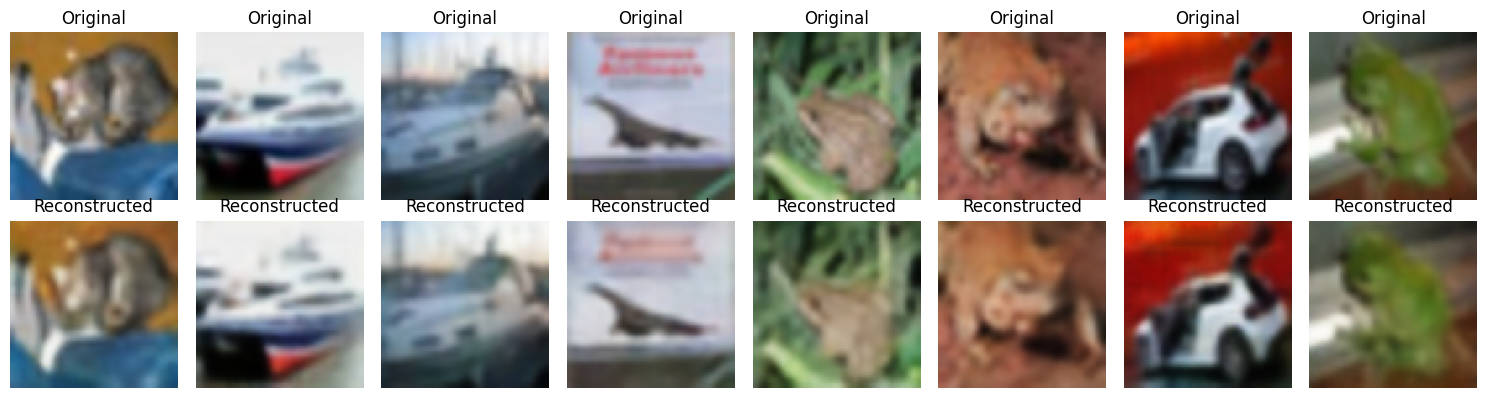

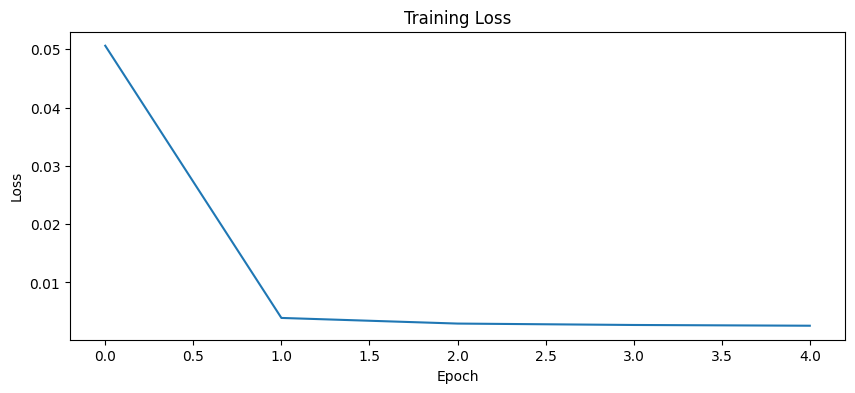

Model saved as 'vqvae_model.pth'


In [ ]:
if __name__ == "__main__":
    # Hyperparameters
    BATCH_SIZE = 32
    LEARNING_RATE = 1e-3
    NUM_EPOCHS = 5

    # Setup data
    print("Setting up data...")
    train_dataset, test_dataset = setup_kaggle_data("cifar10")

    if train_dataset is not None:
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

        # Initialize model
        print("Initializing VQ-VAE model...")
        model = VQVAE(
            in_channels=3,
            hidden_dim=128,
            embedding_dim=64,
            num_embeddings=512,
            commitment_cost=0.25
        ).to(device)

        print(f"Model has {sum(p.numel() for p in model.parameters())} parameters")

        # Train the model
        print("Starting training...")
        train_losses = train_vqvae(model, train_loader, NUM_EPOCHS, LEARNING_RATE)

        # Visualize results
        print("Visualizing reconstructions...")
        visualize_reconstructions(model, test_loader)

        # Plot training loss
        plt.figure(figsize=(10, 4))
        plt.plot(train_losses)
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

        # Save model
        torch.save(model.state_dict(), 'vqvae_model.pth')
        print("Model saved as 'vqvae_model.pth'")